# LSTM multivariado

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf

In [2]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [3]:
df = df.between_time('08:00:00','17:00:00')
df.head()

,DC,PAAVG1H,PAMAX1H,PAMIN1H,PRSUM1H,RHAVG1H,RHMAX1H,RHMIN1H,SRDIFAVG1H,SRDIFMAX1H,SRDIFMIN1H,SRDIFSUM1H,SRGLOAVG1H,SRGLOMAX1H,SRGLOMIN1H,SRGLOSUM1H,TAAVG1H,TAMAX1H,TAMIN1H,TS1AVG1H,TS1MAX1H,TS1MIN1H,TS2AVG1H,TS2MAX1H,TS2MIN1H,TS3AVG1H,TS3MAX1H,TS3MIN1H,TS4AVG1H,TS4MAX1H,TS4MIN1H,TS5AVG1H,TS5MAX1H,TS5MIN1H,TS6AVG1H,TS6MAX1H,TS6MIN1H,TS7AVG1H,TS7MAX1H,TS7MIN1H,WD1HA,WD1HX,WDGM,WGD1HX,WGDH,WR1H,WS1HA,WS1HM,WS1HX
Local_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 08:00:00,13.9,743.5,743.7,743.1,0.0,94,96,89,97.0,145.0,37.0,5836.0,107.0,162.0,40.0,6404.0,10.6,12.2,9.5,10.3,11.9,9.3,10.6,12.0,9.7,11.1,12.1,10.5,12.1,12.3,12.0,13.7,13.8,13.7,15.0,15.0,15.0,15.0,15.0,15.0,42,91,54,46.0,7.0,37.0,2.5,0.4,4.6
2015-01-01 09:00:00,15.0,743.8,743.9,743.7,0.0,84,89,76,224.0,514.0,120.0,13469.0,394.0,781.0,136.0,23646.0,13.5,15.1,12.2,13.2,14.9,11.9,13.1,14.4,12.0,12.8,13.6,12.1,12.6,12.9,12.3,13.7,13.7,13.7,15.0,15.0,15.0,15.0,15.0,15.0,59,111,42,69.0,8.0,49.0,3.3,0.0,5.8
2015-01-01 10:00:00,15.0,743.7,743.9,743.4,0.0,68,79,57,219.0,329.0,97.0,13163.0,728.0,1197.0,373.0,43654.0,16.3,18.1,15.1,17.2,19.7,14.9,16.4,18.5,14.4,14.8,16.1,13.6,13.3,13.8,12.9,13.7,13.7,13.7,15.0,15.0,15.0,15.0,15.0,15.0,40,175,41,28.0,9.0,66.0,4.4,0.0,8.4
2015-01-01 11:00:00,14.7,743.2,743.4,742.8,0.0,62,66,58,365.0,471.0,284.0,21929.0,428.0,667.0,303.0,25688.0,17.2,18.4,16.7,18.8,20.0,18.0,18.0,18.7,17.4,16.0,16.2,15.9,14.0,14.2,13.8,13.8,13.8,13.7,15.0,15.0,15.0,15.0,15.0,15.0,35,153,26,29.0,10.0,61.0,4.0,0.0,8.1
2015-01-01 12:00:00,14.8,742.6,742.9,742.3,0.0,60,65,55,371.0,678.0,166.0,22262.0,403.0,879.0,172.0,24204.0,17.7,18.5,17.2,18.1,18.6,17.4,17.5,17.9,17.1,16.0,16.3,15.9,14.4,14.5,14.2,13.9,13.9,13.8,15.0,15.0,15.0,15.0,15.0,15.0,34,162,40,7.0,11.0,54.0,3.5,0.0,7.6


In [4]:
df = df[['SRGLOAVG1H','TAMAX1H','WS1HA','RHMAX1H']]

In [5]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')

In [6]:
df_test = df_test[['SRGLOAVG1H','TAMAX1H','WS1HA','RHMAX1H']]

In [7]:
df_test = df_test.between_time('08:00:00','17:00:00')

In [57]:
df_test.head()

,SRGLOAVG1H,TAMAX1H,WS1HA,RHMAX1H
Local_Time,,,,
2015-10-20 08:00:00,222.0,13.9,2.2,88
2015-10-20 09:00:00,660.0,16.0,4.5,82
2015-10-20 10:00:00,736.0,17.8,4.7,73
2015-10-20 11:00:00,402.0,17.4,4.6,70
2015-10-20 12:00:00,533.0,18.8,4.5,68


## Variables exógenas como entrada

In [58]:
scaler = MinMaxScaler()

In [59]:
scaler.fit(df)

MinMaxScaler()

In [60]:
scaled_train = scaler.transform(df)
scaled_test = scaler.transform(df_test)

In [61]:
scaled_train[6:10,0]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313])

In [62]:
scaled_train[:,1:]

array([[0.40860215, 0.26966292, 0.94285714],
       [0.56451613, 0.35955056, 0.84285714],
       [0.72580645, 0.48314607, 0.7       ],
       ...,
       [0.68817204, 0.41573034, 0.48571429],
       [0.68817204, 0.3258427 , 0.6       ],
       [0.62365591, 0.20224719, 0.81428571]])

In [63]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [72]:
n_input = 6 # horas hacia atrás, features
n_output = 6 # horas predichas
n_features = 3 # variables de entrada
generator = TimeseriesGenerator(scaled_train[:,1:], scaled_train[:,0], length=n_input, batch_size=n_output)

In [73]:
X,y = generator[0]

In [74]:
X

array([[[0.40860215, 0.26966292, 0.94285714],
        [0.56451613, 0.35955056, 0.84285714],
        [0.72580645, 0.48314607, 0.7       ],
        [0.74193548, 0.43820225, 0.51428571],
        [0.74731183, 0.38202247, 0.5       ],
        [0.83333333, 0.30337079, 0.44285714]],

       [[0.56451613, 0.35955056, 0.84285714],
        [0.72580645, 0.48314607, 0.7       ],
        [0.74193548, 0.43820225, 0.51428571],
        [0.74731183, 0.38202247, 0.5       ],
        [0.83333333, 0.30337079, 0.44285714],
        [0.81182796, 0.34831461, 0.38571429]],

       [[0.72580645, 0.48314607, 0.7       ],
        [0.74193548, 0.43820225, 0.51428571],
        [0.74731183, 0.38202247, 0.5       ],
        [0.83333333, 0.30337079, 0.44285714],
        [0.81182796, 0.34831461, 0.38571429],
        [0.8655914 , 0.23595506, 0.4       ]],

       [[0.74193548, 0.43820225, 0.51428571],
        [0.74731183, 0.38202247, 0.5       ],
        [0.83333333, 0.30337079, 0.44285714],
        [0.81182796, 0.34831

In [75]:
y

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [76]:
X.shape

(6, 6, 3)

In [77]:
X_train = []

In [78]:
y_train = []

In [79]:
generator[0][1]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [80]:
for batch in generator:
  if(len(batch[1])==6):
    X_train.append(batch[0][0])
    y_train.append(batch[1])


Se encuentran los datos de las variables seis horas antes y la radiación solar de las seis horas siguientes.

In [81]:
X_train = np.array(X_train)

In [82]:
X_train.shape

(485, 6, 3)

In [83]:
y_train = np.array(y_train)

In [84]:
y_train.shape

(485, 6)

## Creación del modelo

In [94]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [95]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               41600     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 42,206
Trainable params: 42,206
Non-trainable params: 0
_________________________________________________________________


In [96]:
# fit model
model.fit(X_train,y_train,epochs=10)
#model.fit(generator,epochs=5)

Epoch 1/10
16/16 [==============================] - 2s 9ms/step - loss: 0.1132
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0502
Epoch 3/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0397
Epoch 4/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0395
Epoch 5/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0382
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0379
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0366
Epoch 8/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0366
Epoch 9/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0352
Epoch 10/10
16/16 [==============================] - 0s 10ms/step - loss: 0.0352


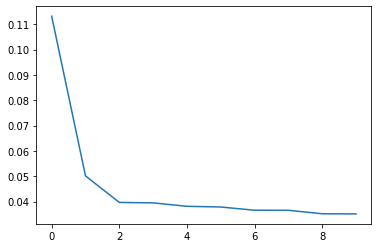

In [97]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [98]:
X_train[0].shape

(6, 3)

Datos de las últimas seis horas de entrenamiento

In [99]:
eval = scaled_train[-6:,1:].reshape(1,6,3)

In [100]:
predictions = model.predict(eval)[0]

In [101]:
predictions

array([0.271741  , 0.2966828 , 0.3163432 , 0.34660253, 0.34828877,
       0.3459357 ], dtype=float32)

In [102]:
scaled_test[0][0]

0.17290108063175394

In [103]:
# create empty table 
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features) )

In [104]:
test_predictions.shape

(6, 4)

In [105]:
test_predictions[:,0] = predictions

In [106]:
test_predictions[0]

array([0.271741, 0.      , 0.      , 0.      ])

In [107]:
true_predictions = scaler.inverse_transform(test_predictions)

In [108]:
true_predictions[:,0]

array([340.90442637, 370.9094142 , 394.56085551, 430.96284273,
       432.99139571, 430.1606499 ])

In [110]:
df_test['SRGLOAVG1H'][:6]

Local_Time
2015-10-20 08:00:00    222.0
2015-10-20 09:00:00    660.0
2015-10-20 10:00:00    736.0
2015-10-20 11:00:00    402.0
2015-10-20 12:00:00    533.0
2015-10-20 13:00:00    688.0
Name: SRGLOAVG1H, dtype: float64

## Variables exógenas y radiación solar como entrada

In [111]:
n_input = 6 # horas hacia atrás, features
n_output = 6 # horas predichas
n_features = 3 # variables de entrada
generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=n_output)

In [113]:
X_train = []
y_train = []

In [114]:
for batch in generator:
  if(len(batch[1])==n_output):
    X_train.append(batch[0][0])
    y_train.append(batch[1])

In [117]:
scaled_train[0]

array([0.07730673, 0.40860215, 0.26966292, 0.94285714])

In [116]:
X_train[0]

array([[0.07730673, 0.40860215, 0.26966292, 0.94285714],
       [0.31587697, 0.56451613, 0.35955056, 0.84285714],
       [0.59351621, 0.72580645, 0.48314607, 0.7       ],
       [0.34413965, 0.74193548, 0.43820225, 0.51428571],
       [0.32335827, 0.74731183, 0.38202247, 0.5       ],
       [0.57772236, 0.83333333, 0.30337079, 0.44285714]])

In [121]:
scaled_train[6:12,0]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [119]:
y_train[0]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [125]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [145]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features+1)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [146]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               42000     
                                                                 
 dense_7 (Dense)             (None, 6)                 606       
                                                                 
Total params: 42,606
Trainable params: 42,606
Non-trainable params: 0
_________________________________________________________________


In [148]:
model.fit(X_train,y_train,epochs=12)

Epoch 1/12
16/16 [==============================] - 0s 9ms/step - loss: 0.0371
Epoch 2/12
16/16 [==============================] - 0s 9ms/step - loss: 0.0360
Epoch 3/12
16/16 [==============================] - 0s 9ms/step - loss: 0.0349
Epoch 4/12
16/16 [==============================] - 0s 9ms/step - loss: 0.0336
Epoch 5/12
16/16 [==============================] - 0s 9ms/step - loss: 0.0331
Epoch 6/12
16/16 [==============================] - 0s 9ms/step - loss: 0.0318
Epoch 7/12
16/16 [==============================] - 0s 7ms/step - loss: 0.0314
Epoch 8/12
16/16 [==============================] - 0s 8ms/step - loss: 0.0300
Epoch 9/12
16/16 [==============================] - 0s 8ms/step - loss: 0.0287
Epoch 10/12
16/16 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 11/12
16/16 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 12/12
16/16 [==============================] - 0s 7ms/step - loss: 0.0269


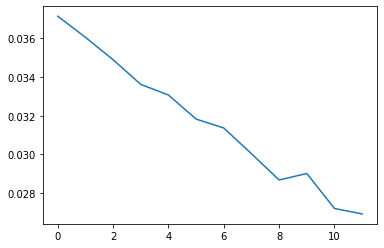

In [149]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [150]:
eval = scaled_train[-6:,:].reshape(1,6,4)

In [151]:
eval

array([[[0.46051538, 0.65053763, 0.53932584, 0.61428571],
        [0.53782211, 0.70967742, 0.47191011, 0.57142857],
        [0.36242727, 0.68817204, 0.35955056, 0.54285714],
        [0.27847049, 0.68817204, 0.41573034, 0.48571429],
        [0.14131338, 0.68817204, 0.3258427 , 0.6       ],
        [0.09143807, 0.62365591, 0.20224719, 0.81428571]]])

In [152]:
predictions = model.predict(eval)[0]
predictions

array([0.14359568, 0.20547913, 0.26106066, 0.3463882 , 0.40476418,
       0.43573323], dtype=float32)

In [153]:
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features) )

In [154]:
test_predictions[:,0] = predictions

In [155]:
true_predictions = scaler.inverse_transform(test_predictions)

In [156]:
true_predictions[:,0]

array([186.74560376, 261.19139357, 328.05596811, 430.70499375,
       500.93130302, 538.18707439])

In [157]:
df_test['SRGLOAVG1H'][:6]

Local_Time
2015-10-20 08:00:00    222.0
2015-10-20 09:00:00    660.0
2015-10-20 10:00:00    736.0
2015-10-20 11:00:00    402.0
2015-10-20 12:00:00    533.0
2015-10-20 13:00:00    688.0
Name: SRGLOAVG1H, dtype: float64

In [158]:
df_compare = pd.DataFrame()

In [159]:
df_compare['RSG'] = df_test['SRGLOAVG1H'][:6].values

In [160]:
df_compare['prediction'] = true_predictions[:,0]

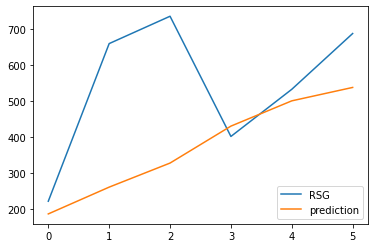

In [161]:
df_compare.plot()